In [97]:
!python -V

Python 3.12.3


In [98]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)


Current Working Directory: /workspaces/Course-MLOps/02-intro


In [99]:
import pandas as pd
import numpy as np

In [100]:
np.set_printoptions(threshold=np.inf, linewidth=200, formatter={'float': '{: 0.3f}'.format})

pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 100)

In [101]:
import pickle

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import (
    LinearRegression,
    RANSACRegressor,
    HuberRegressor,
    TheilSenRegressor,
    Lasso, 
    Ridge
)

from sklearn.metrics import (
    mean_squared_error, 
    root_mean_squared_error
)

In [104]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split

In [105]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db") #sets the sqlite up for storing artifacts
mlflow.set_experiment("nyc-taxi-experiment") # this is the experiment. It will try to recognize if the experiment exist and, If not, it will create a new one. 

<Experiment: artifact_location='/workspaces/Course-MLOps/02-intro/mlruns/1', creation_time=1720013781052, experiment_id='1', last_update_time=1720013781052, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [106]:
df = pd.read_parquet('./data/green_tripdata_2021.parquet')

df.isna().any()


lpep_pickup_datetime     False
lpep_dropoff_datetime    False
PULocationID             False
DOLocationID             False
trip_distance            False
VendorID                 False
trip_type                False
duration                 False
dtype: bool

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37054 entries, 0 to 37053
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   lpep_pickup_datetime   37054 non-null  datetime64[us]
 1   lpep_dropoff_datetime  37054 non-null  datetime64[us]
 2   PULocationID           37054 non-null  int64         
 3   DOLocationID           37054 non-null  int64         
 4   trip_distance          37054 non-null  float64       
 5   VendorID               37054 non-null  int64         
 6   trip_type              37054 non-null  float64       
 7   duration               37054 non-null  float64       
dtypes: datetime64[us](2), float64(3), int64(3)
memory usage: 2.3 MB


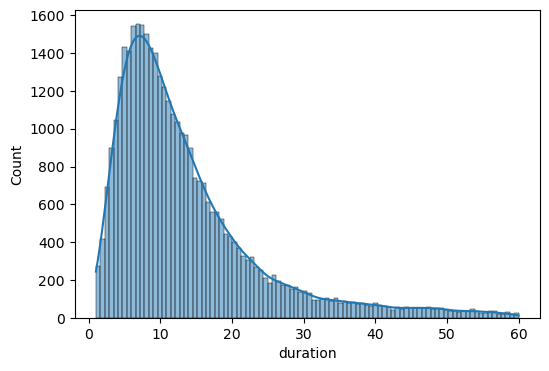

In [108]:
plt.figure(figsize=(6, 4))

sns.histplot(df.duration, kde=True)

plt.show()

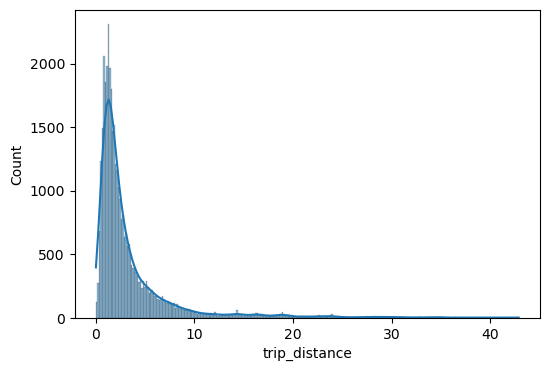

In [109]:
plt.figure(figsize=(6, 4))

sns.histplot(df.trip_distance, kde=True)

plt.show()

In [110]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

# TransformLog = FunctionTransformer(func=np.log1p)

# xx = TransformLog.transform(df.trip_distance)

pipeline = Pipeline([
    ('custom', FunctionTransformer(func=np.log1p)),
    # ('scaler', MinMaxScaler()),
    ('scaler', StandardScaler())
])

trip_distance_trans = ColumnTransformer(
    transformers=[
        ("transform", pipeline, ['trip_distance']),
    ], 
).set_output(transform='pandas')

xx = trip_distance_trans.fit_transform(df[['trip_distance']])


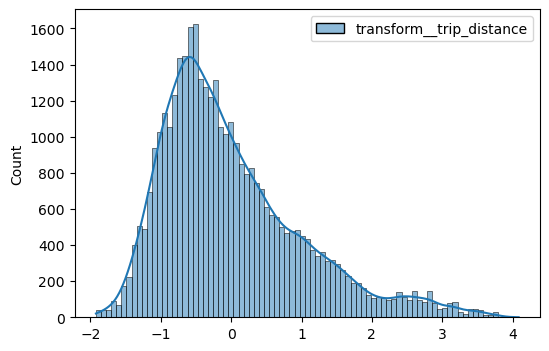

In [111]:
plt.figure(figsize=(6, 4))

sns.histplot(xx, kde=True)

plt.show()

In [112]:
# Verifying if a categorical variable is a string. 
# categorical = ['VendorID', 'trip_type']
categorical = ['trip_type']
numerical = ['trip_distance']
label = ['duration']

categorical_columns = [col for col in categorical if col in df.columns]

for column in categorical_columns:
    if df[column].dtype == 'object': 
        print(f"{column} is already of type str")
    else:
        print(f"{column} is not of type str")
        df[column] = df[column].astype(str)

df.dtypes

trip_type is not of type str


lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
PULocationID                      int64
DOLocationID                      int64
trip_distance                   float64
VendorID                          int64
trip_type                        object
duration                        float64
dtype: object

In [113]:
# transform numeric features
numeric_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="median")), 
           ('custom', FunctionTransformer(func=np.log1p)),
           ("scaler", StandardScaler())
           ]
)

# transform categorical features
categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
           ("onehot", OneHotEncoder(sparse_output=False, drop= 'first', dtype = np.int64))
           ]
)

# combine both transformations
col_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numerical),
        ("categorical", categorical_transformer, categorical)
    ], 
    remainder='passthrough'    
).set_output(transform='pandas')


In [114]:
X = df[categorical + numerical]
# X = col_transformer.fit_transform(X)
y = df[label]


In [115]:
X.shape, y.shape

((37054, 2), (37054, 1))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(25937, 11117, 25937, 11117)

#### ***Linear Regression***
---

In [117]:
# Train the model
model_reg = Pipeline(steps=[('preprocessor', col_transformer), ('model', LinearRegression(fit_intercept=True))])

model_reg.fit(X_train, y_train)

print("Estimated coefficients Linear:")
print(model_reg.named_steps['model'].intercept_, model_reg.named_steps['model'].coef_)

y_pred = model_reg.predict(X_test)

mean_squared_error(y_pred, y_test), root_mean_squared_error(y_pred, y_test)


Estimated coefficients Linear:
[ 13.619] [[ 8.961  0.475]]


(28.358832634792744, 5.325301177848324)

In [118]:
# That one will only be used if the col_transformer is applied directly to X. 

# model = LinearRegression(fit_intercept=True).fit(X_train, y_train)

# print("Estimated coefficients Linear:")
# print(model.intercept_, model.coef_)

# y_pred = model.predict(X_test)

# mean_squared_error(y_pred, y_test), root_mean_squared_error(y_pred, y_test)

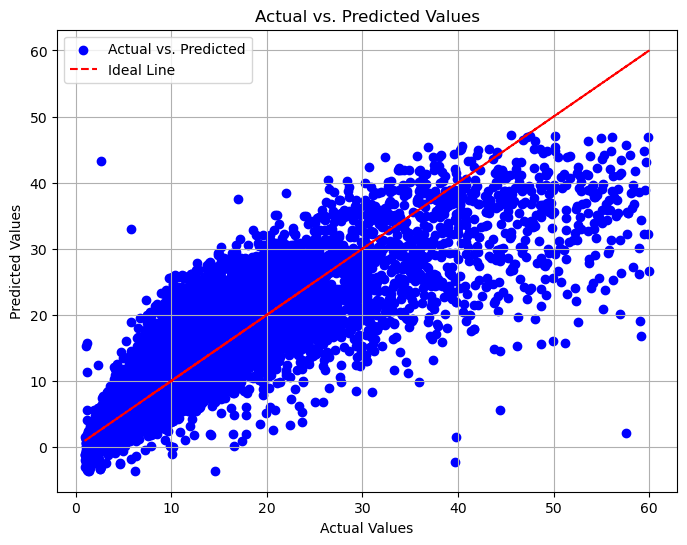

In [119]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Ideal Line')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

##### ***save the model***

In [120]:
with open('models/linear_reg.bin', 'wb') as f_out:
    pickle.dump((model_reg), f_out)

#### ***RANSACRegressor***
---

In [121]:
# Train the model
model_ransac = Pipeline(steps=[('preprocessor', col_transformer), ('model', RANSACRegressor(random_state = 123) )])

model_ransac.fit(X_train, y_train)

print("Estimated coefficients Linear:")
print(model_ransac.named_steps['model'].estimator_.intercept_, model_ransac.named_steps['model'].estimator_.coef_)

y_pred = model_ransac.predict(X_test)

mean_squared_error(y_pred, y_test), root_mean_squared_error(y_pred, y_test)

Estimated coefficients Linear:
[ 12.089] [[ 7.028  0.123]]


(33.65684452810096, 5.801451932757951)

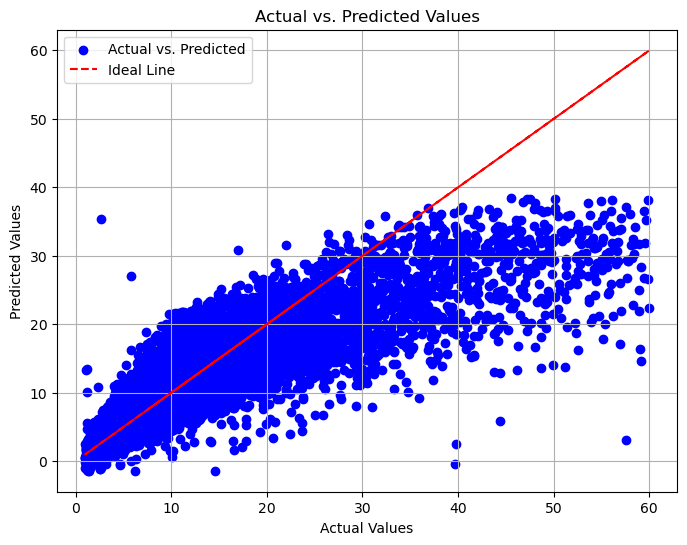

In [122]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Ideal Line')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

#### ***HuberRegressor***
---

In [123]:
# Train the model
model_huber = Pipeline(steps=[('preprocessor', col_transformer), ('model', HuberRegressor(fit_intercept = True) )])

model_huber.fit(X_train, np.ravel(y_train, order='C'))

print("Estimated coefficients Linear:")
print(model_huber.named_steps['model'].intercept_, model_huber.named_steps['model'].coef_)

y_pred = model_huber.predict(X_test)

mean_squared_error(y_pred, y_test), root_mean_squared_error(y_pred, y_test)

Estimated coefficients Linear:
13.023112336711346 [ 8.202  0.695]


(29.040349677811008, 5.3889098784272695)

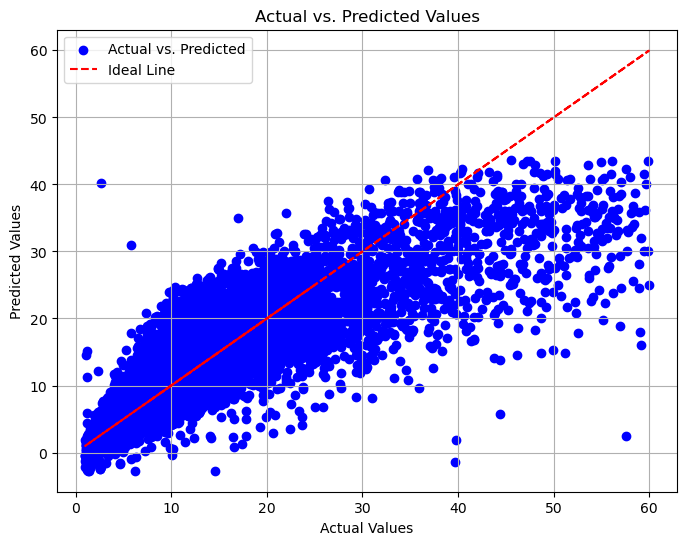

In [124]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Ideal Line')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

#### ***TheilSenRegressor***
---

In [125]:
# Train the model
model_theil = Pipeline(steps=[('preprocessor', col_transformer), ('model', TheilSenRegressor(fit_intercept = True, random_state = 42) )])

model_theil.fit(X_train, np.ravel(y_train, order='C'))

print("Estimated coefficients Linear:")
print(model_theil.named_steps['model'].intercept_, model_theil.named_steps['model'].coef_)

y_pred = model_theil.predict(X_test)

mean_squared_error(y_pred, y_test), root_mean_squared_error(y_pred, y_test)

Estimated coefficients Linear:
12.869117404176619 [ 7.957  0.011]


(29.595004872166015, 5.440129122747549)

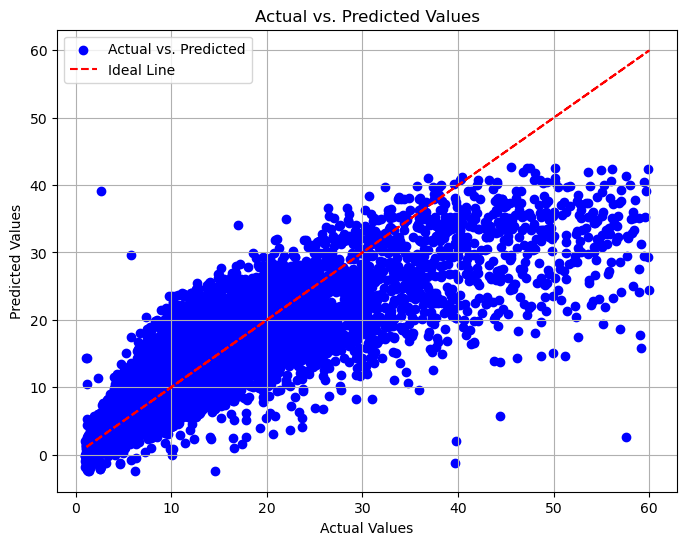

In [126]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Ideal Line')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

#### ***Ridge***
---

In [127]:
# Train the model

with mlflow.start_run(run_name='trial_01'): 

    mlflow.set_tag('developer', 'Bruno')

    mlflow.log_param('data-path', './data/green_tripdata_2021.parquet' )

    alpha_ = 0.1
    mlflow.log_param('alpha', alpha_)
    model_ridge = Pipeline(steps=[('preprocessor', col_transformer), ('model', Ridge(alpha = alpha_, fit_intercept = True, random_state = 42) )])

    model_ridge.fit(X_train, np.ravel(y_train, order='C'))

    print("Estimated coefficients Linear:")
    print(model_ridge.named_steps['model'].intercept_, model_ridge.named_steps['model'].coef_)

    y_pred = model_ridge.predict(X_test)

    # mean_squared_error(y_pred, y_test)
    rmse = root_mean_squared_error(y_pred, y_test)
    mlflow.log_metric('RMSE', rmse)

    with open('models/model_ridge.bin', 'wb') as f_out:
        pickle.dump((model_ridge), f_out)

    mlflow.log_artifact(local_path="models/model_ridge.bin", artifact_path="models_pickle")

Estimated coefficients Linear:
13.618913507944798 [ 8.961  0.475]


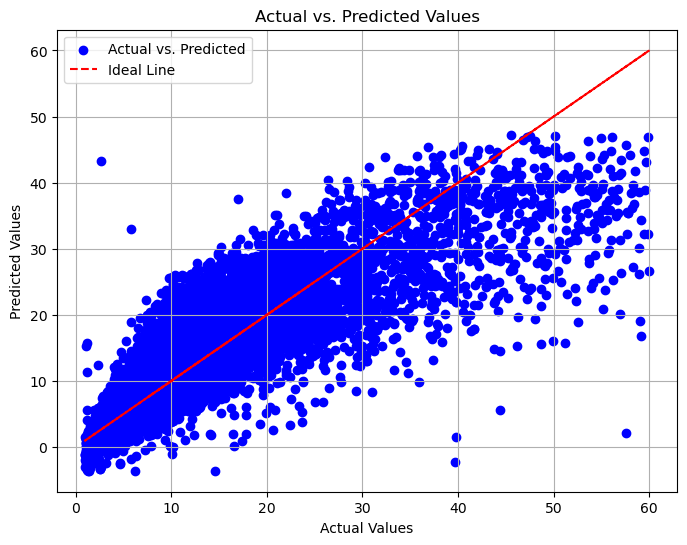

In [128]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Ideal Line')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()